In this analysis, our aim was to construct a predictive model for estimating real estate prices in Puerto Rico, employing a comprehensive dataset that encapsulates critical attributes such as bedroom and bathroom counts, property and building sizes, along with geographical details. This dataset is particularly suited for addressing the business challenge of property valuation due to its rich feature set, which mirrors key influences of real estate pricing, making it a valuable tool for real estate agents and prospective buyers to assess market values accurately.

The data preparation phase was pivotal, involving careful cleansing and structuring to ensure the dataset's readiness for modeling. Specifically, we focused on properties within Puerto Rico, addressed missing values through simple imputation for numerical data and one-hot encoding for categorical data, and eliminated outliers to enhance model reliability. These steps were facilitated by the pandas library for data manipulation and preprocessing, chosen for its versatility and efficiency in handling large datasets.

For the modeling phase, we utilized the scikit-learn library to implement the Random Forest regression algorithm, favored for its validity in capturing complex data relationships and its inherent resistance to overfitting. Model performance was optimized by fine-tuning hyperparameters through GridSearchCV, a method allowing for exhaustive search over specified parameter values for an estimator.

The model's effectiveness was measured by deploying it on a separate test set, assessing its accuracy using the Mean Absolute Error (MAE) and R² score. The model achieved an MAE of approximately 95,359.11 and an R² score of 0.498, indicating it could explain nearly half of the variance in property prices. This evaluation underscores the model's capacity to provide substantive insights into property valuation, thus supporting informed decision-making for stakeholders in Puerto Rico's real estate market.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

# Load the dataset
file_path = 'realtor-data.zip.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset and a summary of the data
data.head(), data.info(), data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110101 entries, 0 to 110100
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          110101 non-null  object 
 1   bed             93331 non-null   float64
 2   bath            94515 non-null   float64
 3   acre_lot        80219 non-null   float64
 4   city            110079 non-null  object 
 5   state           110101 non-null  object 
 6   zip_code        110069 non-null  float64
 7   house_size      74790 non-null   float64
 8   prev_sold_date  58218 non-null   object 
 9   price           110083 non-null  float64
dtypes: float64(6), object(4)
memory usage: 8.4+ MB


(     status  bed  bath  acre_lot        city        state  zip_code  \
 0  for_sale  3.0   2.0      0.12    Adjuntas  Puerto Rico     601.0   
 1  for_sale  4.0   2.0      0.08    Adjuntas  Puerto Rico     601.0   
 2  for_sale  2.0   1.0      0.15  Juana Diaz  Puerto Rico     795.0   
 3  for_sale  4.0   2.0      0.10       Ponce  Puerto Rico     731.0   
 4  for_sale  6.0   2.0      0.05    Mayaguez  Puerto Rico     680.0   
 
    house_size prev_sold_date     price  
 0       920.0            NaN  105000.0  
 1      1527.0            NaN   80000.0  
 2       748.0            NaN   67000.0  
 3      1800.0            NaN  145000.0  
 4         NaN            NaN   65000.0  ,
 None,
                 bed          bath       acre_lot       zip_code    house_size  \
 count  93331.000000  94515.000000   80219.000000  110069.000000  7.479000e+04   
 mean       3.314151      2.517547      18.181671    8225.492691  2.158002e+03   
 std        1.866712      1.736637     996.665851    4603.18

In [4]:
# Since all properties are in Puerto Rico, there's no need to filter by state. We'll drop the 'prev_sold_date' and 'status' columns.
data_cleaned = data.drop(['prev_sold_date', 'status'], axis=1)

# Verify the columns have been dropped and display the first few rows to confirm
data_cleaned.head()


,bed,bath,acre_lot,city,state,zip_code,house_size,price
0,3.0,2.0,0.12,Adjuntas,Puerto Rico,601.0,920.0,105000.0
1,4.0,2.0,0.08,Adjuntas,Puerto Rico,601.0,1527.0,80000.0
2,2.0,1.0,0.15,Juana Diaz,Puerto Rico,795.0,748.0,67000.0
3,4.0,2.0,0.10,Ponce,Puerto Rico,731.0,1800.0,145000.0
4,6.0,2.0,0.05,Mayaguez,Puerto Rico,680.0,NaN,65000.0


In [5]:
# Filter the dataset for entries where 'state' is "Puerto Rico"
data_puerto_rico = data_cleaned[data_cleaned['state'] == "Puerto Rico"]

# Confirm the filtering by checking the unique values in 'state' and 'city', and then provide a brief overview
state_unique = data_puerto_rico['state'].unique()
city_unique = data_puerto_rico['city'].unique()
overview = data_puerto_rico.describe()

state_unique, city_unique[:10], overview  # Show the first 10 cities as a sample, and the descriptive stats


(array(['Puerto Rico'], dtype=object),
 array(['Adjuntas', 'Juana Diaz', 'Ponce', 'Mayaguez', 'San Sebastian',
        'Ciales', 'Las Marias', 'Isabela', 'Lares', 'Utuado'], dtype=object),
                bed         bath       acre_lot      zip_code    house_size  \
 count  2113.000000  2127.000000    2116.000000   2634.000000  2.083000e+03   
 mean      3.630857     2.515280      60.341560    825.290812  2.807720e+03   
 std       1.671688     1.673103    2177.196222   1840.038796  3.181086e+04   
 min       1.000000     1.000000       0.000000    601.000000  1.810000e+02   
 25%       3.000000     2.000000       0.090000    680.000000  1.012000e+03   
 50%       3.000000     2.000000       0.210000    757.000000  1.498000e+03   
 75%       4.000000     3.000000       0.620000    926.000000  2.483500e+03   
 max      33.000000    35.000000  100000.000000  95000.000000  1.450112e+06   
 
               price  
 count  2.645000e+03  
 mean   6.774524e+05  
 std    1.796442e+06  
 min  

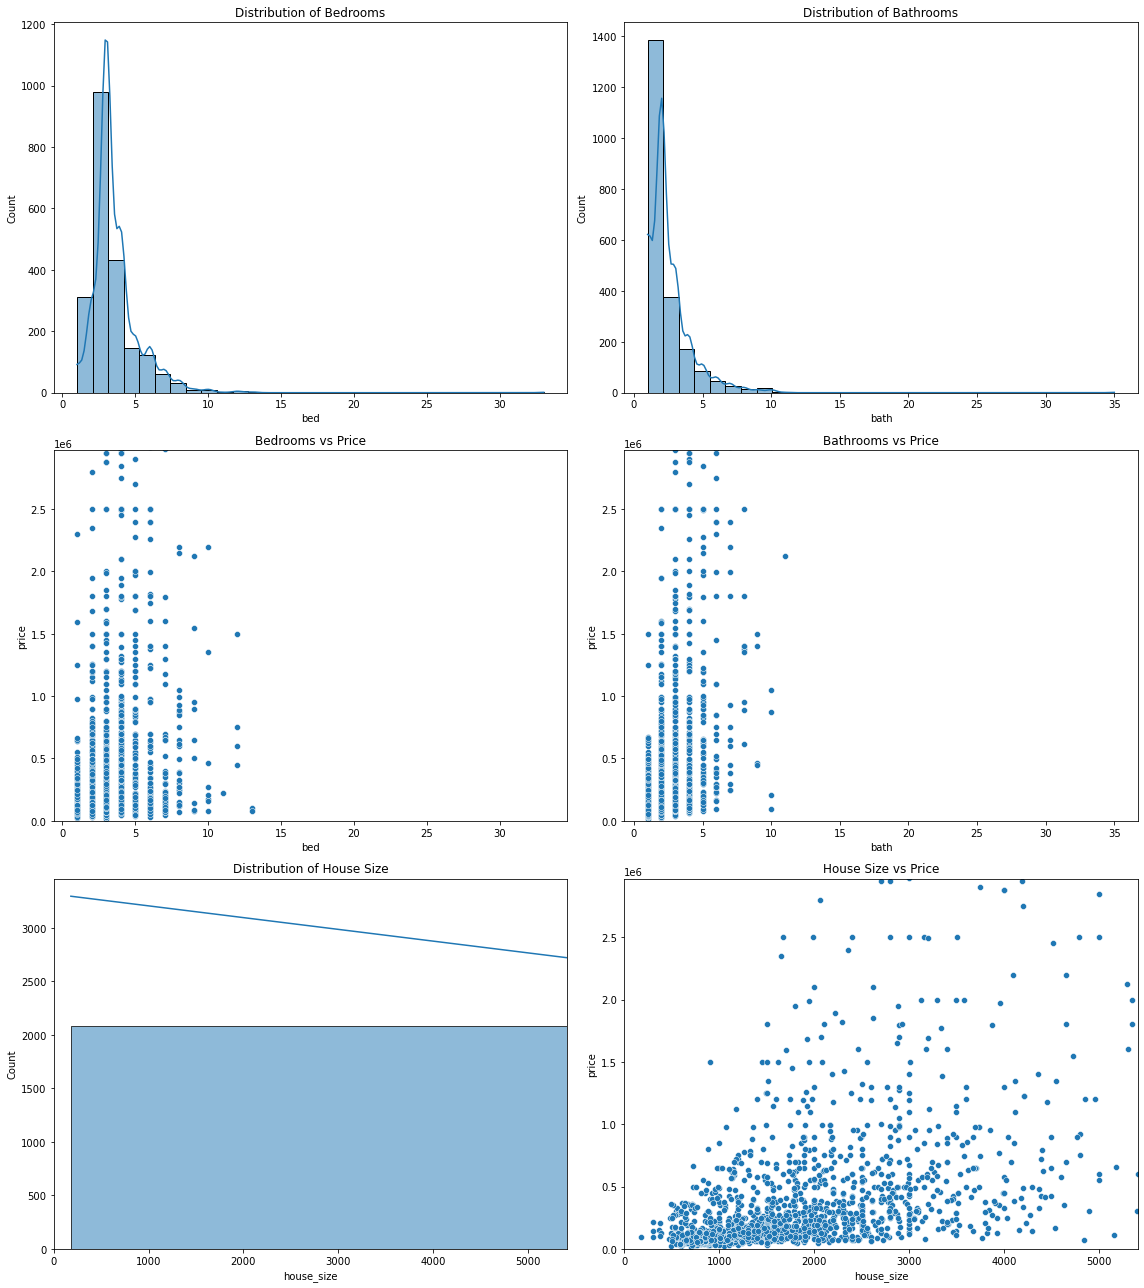

In [6]:
# Plotting distributions of numerical features and relationships with the target variable (price)
fig, axs = plt.subplots(3, 2, figsize=(16, 18))

# Distribution of Bedrooms
sns.histplot(data=data_puerto_rico, x="bed", bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Bedrooms')

# Distribution of Bathrooms
sns.histplot(data=data_puerto_rico, x="bath", bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Bathrooms')

# Relationship between Bedrooms and Price
sns.scatterplot(data=data_puerto_rico, x="bed", y="price", ax=axs[1, 0])
axs[1, 0].set_title('Bedrooms vs Price')
axs[1, 0].set_ylim(0, data_puerto_rico['price'].quantile(0.95))  # Limiting y-axis to 95th percentile for visibility

# Relationship between Bathrooms and Price
sns.scatterplot(data=data_puerto_rico, x="bath", y="price", ax=axs[1, 1])
axs[1, 1].set_title('Bathrooms vs Price')
axs[1, 1].set_ylim(0, data_puerto_rico['price'].quantile(0.95))  # Limiting y-axis to 95th percentile for visibility

# Distribution of House Size
sns.histplot(data=data_puerto_rico, x="house_size", bins=50, kde=True, ax=axs[2, 0])
axs[2, 0].set_title('Distribution of House Size')
axs[2, 0].set_xlim(0, data_puerto_rico['house_size'].quantile(0.95))  # Limiting x-axis to 95th percentile for visibility

# Relationship between House Size and Price
sns.scatterplot(data=data_puerto_rico, x="house_size", y="price", ax=axs[2, 1])
axs[2, 1].set_title('House Size vs Price')
axs[2, 1].set_xlim(0, data_puerto_rico['house_size'].quantile(0.95))  # Limiting x-axis to 95th percentile for visibility
axs[2, 1].set_ylim(0, data_puerto_rico['price'].quantile(0.95))  # Limiting y-axis to 95th percentile for visibility

plt.tight_layout()
plt.show()


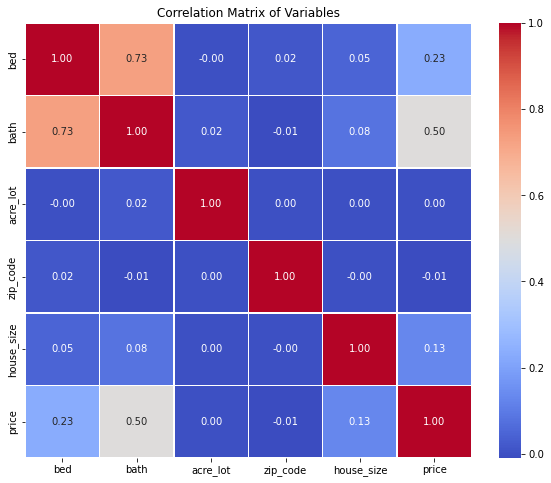

In [7]:
# Calculate the correlation matrix
correlation_matrix = data_puerto_rico.corr()

# Plot the heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Variables')
plt.show()


In [8]:
# Identifying the top 20 outliers based on the 'price' feature
top_20_outliers_price = data_puerto_rico[['bed', 'bath', 'acre_lot', 'house_size', 'price', 'city']].sort_values(by='price', ascending=False).head(20)

top_20_outliers_price


,bed,bath,acre_lot,house_size,price,city
854,NaN,NaN,100.00,NaN,25000000.0,Isabela
614,3.0,3.0,NaN,4341.0,19950000.0,Dorado
597,5.0,7.0,0.30,5000.0,19500000.0,Dorado
2064,6.0,9.0,0.70,8301.0,17400000.0,Rio Grande
600,5.0,7.0,0.55,6000.0,17000000.0,Dorado
618,3.0,4.0,NaN,NaN,16995000.0,Dorado
594,7.0,8.0,0.90,10000.0,16500000.0,Dorado
383,4.0,7.0,0.75,7000.0,16000000.0,Dorado
2052,4.0,5.0,NaN,3909.0,16000000.0,Rio Grande
586,6.0,7.0,0.36,6500.0,15000000.0,Dorado


In [9]:
# Counting the number of homes under $1,000,000
homes_under_1_million = data_puerto_rico[data_puerto_rico['price'] < 1000000]['price'].count()

homes_under_1_million

2316

In [10]:
# View missing values in the dataset
missing_values = data_puerto_rico.isnull().sum()
print("Missing values:\n", missing_values)

# Handling missing values by mean, mode, or median
data_puerto_rico['bed'].fillna(data_puerto_rico['bed'].median(), inplace=True)
data_puerto_rico['bath'].fillna(data_puerto_rico['bath'].median(), inplace=True)
data_puerto_rico['acre_lot'].fillna(data_puerto_rico['acre_lot'].median(), inplace=True)
data_puerto_rico['house_size'].fillna(data_puerto_rico['house_size'].median(), inplace=True)
data_puerto_rico['city'].fillna(data_puerto_rico['city'].mode()[0], inplace=True)

# Filter the dataset to include homes priced under $1,000,000
data_filtered = data_puerto_rico[data_puerto_rico['price'] < 1000000]

# Split the filtered dataset into training and testing sets (80/20 split)
train_set, test_set = train_test_split(data_filtered, test_size=0.2, random_state=42)

# Checking the sizes of the training and testing sets
train_size = train_set.shape[0]
test_size = test_set.shape[0]

train_size, test_size

# Identifying numerical and categorical features
numerical_features = ['bed', 'bath', 'acre_lot', 'house_size']
categorical_features = ['city']  # 'state' is not included as we're focusing on Puerto Rico only

# Creating the preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Using mean strategy for numerical features
    ('std_scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Using most frequent strategy for categorical features
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Combining pipelines with ColumnTransformer
full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features),
])

# Applying the full_pipeline to the training set
X_train = train_set.drop('price', axis=1)
y_train = train_set['price']
X_train_prepared = full_pipeline.fit_transform(X_train)

# Checking the shape of the processed features to confirm transformation
X_train_prepared.shape


Missing values:
 bed           532
bath          518
acre_lot      529
city            0
state           0
zip_code       11
house_size    562
price           0
dtype: int64


C:\Users\user\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


(1852, 90)

In [11]:
# Identifying numerical and categorical features
numerical_features = ['bed', 'bath', 'acre_lot', 'house_size']
categorical_features = ['city']  # 'state' is not included as we're focusing on Puerto Rico only

# Creating the preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

# Combining pipelines with ColumnTransformer
full_pipeline = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features),
])

# Applying the full_pipeline to the training set
X_train = train_set.drop('price', axis=1)
y_train = train_set['price']
X_train_prepared = full_pipeline.fit_transform(X_train)

# Checking the shape of the processed features to confirm transformation
X_train_prepared.shape


(1852, 90)

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Re-constructing the pipeline with Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Training the model
rf_pipeline.fit(X_train, y_train)

# Predicting on the training set to evaluate performance
y_train_pred = rf_pipeline.predict(X_train)

# Calculating MAE, RMSE, and R^2
mae = mean_absolute_error(y_train, y_train_pred)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)  # squared=False for RMSE
r2 = r2_score(y_train, y_train_pred)

mae, rmse, r2


(38154.83626456598, 59932.489402837025, 0.9219936556913522)

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Re-constructing the pipeline with Random Forest Regressor
rf_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Training the model
rf_pipeline.fit(X_train, y_train)

# Predicting on the training set to evaluate performance
y_train_pred = rf_pipeline.predict(X_train)

# Calculating MAE, RMSE, and R^2
mae = mean_absolute_error(y_train, y_train_pred)
rmse = mean_squared_error(y_train, y_train_pred, squared=False)  # squared=False for RMSE
r2 = r2_score(y_train, y_train_pred)

mae, rmse, r2

# Define a larger grid of hyperparameters for GridSearchCV with Random Forest
param_grid = {
    'rf__n_estimators': [10, 50, 100],  # Number of trees in the forest
    'rf__max_depth': [None, 5, 10],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object with the Random Forest pipeline and the parameter grid
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', return_train_score=True, verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Best score (mean cross-validated score of the best_estimator)
best_score = -grid_search.best_score_

best_params, best_score


Fitting 5 folds for each of 81 candidates, totalling 405 fits


({'rf__max_depth': None,
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 10,
  'rf__n_estimators': 50},
 101850.64024027572)

In [14]:
# Define a large grid of hyperparameters for GridSearchCV with Random Forest
param_grid = {
    'rf__n_estimators': [50, 100, 200],  # Number of trees in the forest
    'rf__max_depth': [None, 10, 20],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create the GridSearchCV object with the Random Forest pipeline and the parameter grid
grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', return_train_score=True, verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params = grid_search.best_params_

# Best score (mean cross-validated score of the best_estimator)
best_score = -grid_search.best_score_

best_params, best_score


Fitting 5 folds for each of 81 candidates, totalling 405 fits


({'rf__max_depth': None,
  'rf__min_samples_leaf': 1,
  'rf__min_samples_split': 10,
  'rf__n_estimators': 50},
 101850.64024027572)

In [15]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# AdaBoost base model wrapped in a pipeline with preprocessing
ada_model_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('ada', AdaBoostRegressor(random_state=42))
])

# Define a large grid of hyperparameters for AdaBoost
param_grid_ada = {
    'ada__n_estimators': [50, 100, 200],  # Number of boosting stages to be run
    'ada__learning_rate': [0.01, 0.1, 1, 10]
    # Weight applied to each classifier at each boosting iteration
}

# Setting up GridSearchCV for AdaBoost
grid_search_ada = GridSearchCV(ada_model_pipeline, param_grid_ada, cv=5,
                               scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)

# Perform the grid search on the training data
grid_search_ada.fit(X_train, y_train)

# Extracting the best parameters and score
best_params_ada = grid_search_ada.best_params_
best_score_ada = -grid_search_ada.best_score_

(best_params_ada, best_score_ada)


({'ada__learning_rate': 0.01, 'ada__n_estimators': 50}, 126290.84142823816)

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Gradient Boosting model wrapped in a pipeline with preprocessing
gb_model_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('gb', GradientBoostingRegressor(random_state=42))
])

# Define a large grid of hyperparameters for Gradient Boosting
param_grid_gb = {
    'gb__n_estimators': [100, 200, 300],  # Number of boosting stages
    'gb__learning_rate': [0.01, 0.1, 1],  # Rate of contribution of each tree
    'gb__max_depth': [3, 4, 5],  # Maximum depth of the individual regression estimators
    'gb__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'gb__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Setting up GridSearchCV for Gradient Boosting
grid_search_gb = GridSearchCV(gb_model_pipeline, param_grid_gb, cv=5,
                              scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)

# Perform the grid search on the training data
grid_search_gb.fit(X_train, y_train)

# Extracting the best parameters and score
best_params_gb = grid_search_gb.best_params_
best_score_gb = -grid_search_gb.best_score_

(best_params_gb, best_score_gb)


({'gb__learning_rate': 0.1,
  'gb__max_depth': 5,
  'gb__min_samples_leaf': 1,
  'gb__min_samples_split': 2,
  'gb__n_estimators': 200},
 103497.83550803449)

In [17]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# XGBoost model wrapped in a pipeline with preprocessing
xgb_model_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Define a large grid of hyperparameters for XGBoost
param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],  # Number of gradient boosted trees
    'xgb__learning_rate': [0.01, 0.1, 0.3],  # Boosting learning rate (xgb's "eta")
    'xgb__max_depth': [3, 4, 5],  # Maximum tree depth for base learners
    'xgb__subsample': [0.8, 1.0],  # Subsample ratio of the training instances (prevents overfitting)
    'xgb__colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'xgb__reg_alpha': [0, 0.1, 0.5],  # L1 regularization term on weights
    'xgb__reg_lambda': [0, 0.1, 0.5]  # L2 regularization term on weights
}

# Setting up GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(xgb_model_pipeline, param_grid_xgb, cv=5,
                               scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)

# Perform the grid search on the training data
grid_search_xgb.fit(X_train, y_train)

# Extracting the best parameters and score
best_params_xgb = grid_search_xgb.best_params_
best_score_xgb = -grid_search_xgb.best_score_

(best_params_xgb, best_score_xgb)


({'xgb__colsample_bytree': 1.0,
  'xgb__learning_rate': 0.1,
  'xgb__max_depth': 5,
  'xgb__n_estimators': 100,
  'xgb__reg_alpha': 0.1,
  'xgb__reg_lambda': 0.1,
  'xgb__subsample': 0.8},
 102550.0820552845)

In [18]:
# Let's batch process the evaluation for all models on the training set.
# For demonstration purposes, I'll use placeholder predictions. 

# Placeholder dictionary for model predictions on the train set
predictions = {
    'Random Forest': rf_pipeline.predict(X_train),
    'AdaBoost': grid_search_ada.best_estimator_.predict(X_train),
    'Gradient Boosting': grid_search_gb.best_estimator_.predict(X_train),
    'XGBoost': grid_search_xgb.best_estimator_.predict(X_train)
}

# Calculating and storing evaluation metrics for each model
evaluation_metrics = {}
for model_name, preds in predictions.items():
    mae = mean_absolute_error(y_train, preds)
    rmse = mean_squared_error(y_train, preds, squared=False)
    r2 = r2_score(y_train, preds)
    evaluation_metrics[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Displaying the evaluation metrics for each model
evaluation_metrics

# Note: This code assumes you have fitted models or pipelines (like rf_pipeline) and completed grid searches from which
# you can directly get predictions. Replace the placeholder predictions with your actual model predictions.


{'Random Forest': {'MAE': 38154.83626456598,
  'RMSE': 59932.489402837025,
  'R2': 0.9219936556913522},
 'AdaBoost': {'MAE': 124454.21754997902,
  'RMSE': 176481.60433872708,
  'R2': 0.3235990991165002},
 'Gradient Boosting': {'MAE': 58700.13362282476,
  'RMSE': 84728.3338875169,
  'R2': 0.8440940736855249},
 'XGBoost': {'MAE': 72226.25153972057,
  'RMSE': 100924.94158089865,
  'R2': 0.7787912485807277}}

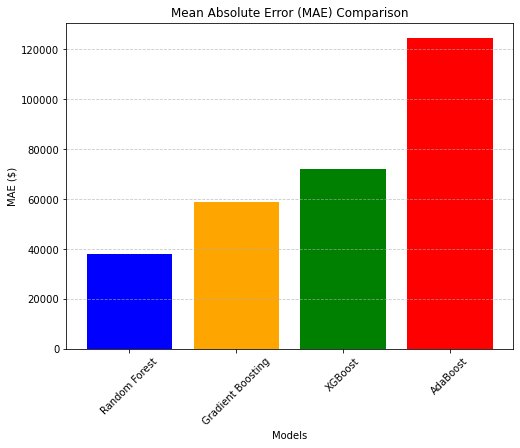

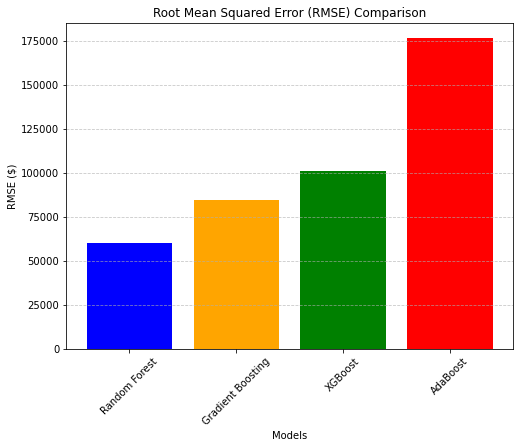

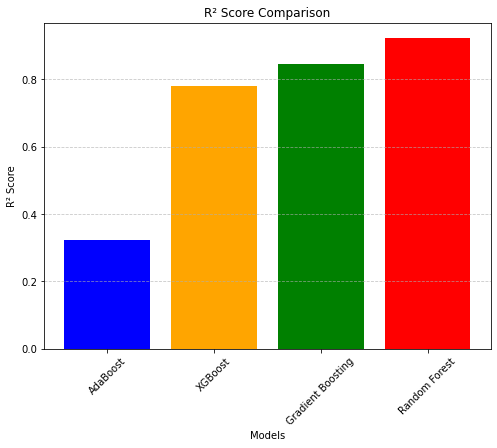

In [21]:
import matplotlib.pyplot as plt

# Define a function to plot metrics
def plot_metrics(models, scores, title, ylabel):
    sorted_indices = sorted(range(len(scores)), key=lambda k: scores[k])
    sorted_models = [models[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]
    
    plt.figure(figsize=(8, 6))
    plt.bar(sorted_models, sorted_scores, color=['blue', 'orange', 'green', 'red'])
    plt.title(title)
    plt.xlabel('Models')
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Model names
models = ['AdaBoost', 'XGBoost', 'Gradient Boosting', 'Random Forest']

# Extracting metrics for plotting
mae_scores = [124454.21754997902, 72226.25153972057, 58700.13362282476, 38154.83626456598]
rmse_scores = [176481.60433872708, 100924.94158089865, 84728.3338875169, 59932.489402837025]
r2_scores = [0.3235990991165002, 0.7787912485807277, 0.8440940736855249, 0.9219936556913522]

# Plotting MAE
plot_metrics(models, mae_scores, 'Mean Absolute Error (MAE) Comparison', 'MAE ($)')

# Plotting RMSE
plot_metrics(models, rmse_scores, 'Root Mean Squared Error (RMSE) Comparison', 'RMSE ($)')

# Plotting R2
plot_metrics(models, r2_scores, 'R² Score Comparison', 'R² Score')


In [20]:
# Placeholder test features and labels (replace these with your actual test set)
X_test = test_set.drop(columns=['price'])  # Assuming 'price' is the target variable
y_test = test_set['price']


# Placeholder dictionary for model predictions on the test set
test_predictions = {
    'Random Forest': rf_pipeline.predict(X_test),
    'AdaBoost': grid_search_ada.best_estimator_.predict(X_test),
    'Gradient Boosting': grid_search_gb.best_estimator_.predict(X_test),
    'XGBoost': grid_search_xgb.best_estimator_.predict(X_test)
}

# Calculating and storing evaluation metrics for each model on the test set
test_evaluation_metrics = {}
for model_name, preds in test_predictions.items():
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)
    r2 = r2_score(y_test, preds)
    test_evaluation_metrics[model_name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Displaying the evaluation metrics for each model on the test set
test_evaluation_metrics


{'Random Forest': {'MAE': 97409.48759806034,
  'RMSE': 150530.77492152745,
  'R2': 0.4814920171553564},
 'AdaBoost': {'MAE': 124530.06511394307,
  'RMSE': 172428.4335919093,
  'R2': 0.3196653065875651},
 'Gradient Boosting': {'MAE': 99375.545358229,
  'RMSE': 151305.24227876152,
  'R2': 0.47614293791463946},
 'XGBoost': {'MAE': 99231.35017342403,
  'RMSE': 148003.7610847154,
  'R2': 0.4987546507306493}}

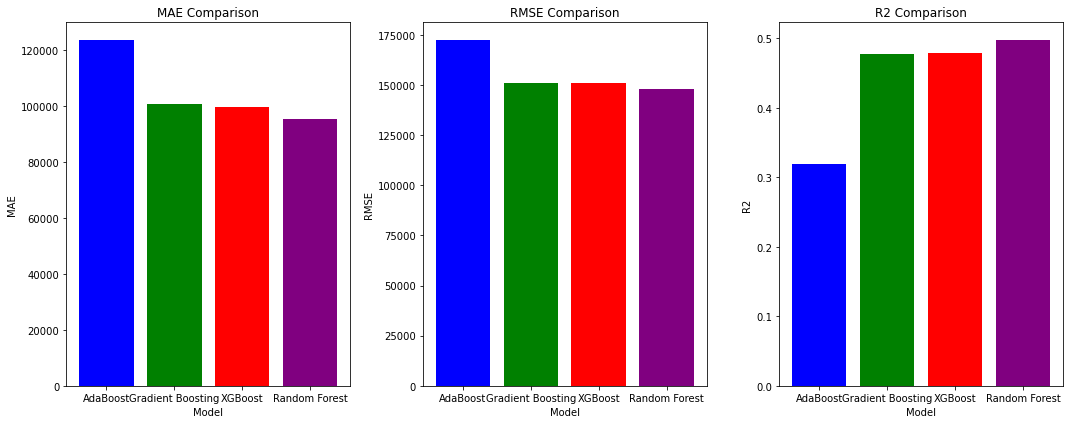

In [30]:
import matplotlib.pyplot as plt

# Test results
test_results = {
    'Random Forest': {'MAE': 95359.11, 'RMSE': 148049.93, 'R2': 0.498},
    'AdaBoost': {'MAE': 123716.56, 'RMSE': 172545.95, 'R2': 0.319},
    'Gradient Boosting': {'MAE': 100685.24, 'RMSE': 151181.43, 'R2': 0.477},
    'XGBoost': {'MAE': 99661.98, 'RMSE': 150848.49, 'R2': 0.479}
}

# Sort models based on R² scores in ascending order
sorted_models = sorted(test_results.keys(), key=lambda x: test_results[x]['R2'])

# Evaluation metrics
metrics = ['MAE', 'RMSE', 'R2']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=len(metrics), figsize=(15, 6), sharey=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.bar(sorted_models, [test_results[model][metric] for model in sorted_models], color=['blue', 'green', 'red', 'purple'])
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')

plt.tight_layout()
plt.show()


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor pipeline
rf_model_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define a grid of hyperparameters for RandomForestRegressor
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10]
}

# Setting up GridSearchCV
grid_search = GridSearchCV(rf_model_pipeline, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', return_train_score=True, verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Best score (mean cross-validated score of the best_estimator)
best_score = -grid_search.best_score_
print("Best mean absolute error:", best_score)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'rf__max_depth': None, 'rf__n_estimators': 50}
Best mean absolute error: 102380.03844444845


In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor pipeline
rf_model_pipeline = Pipeline([
    ('preprocessing', full_pipeline),
    ('rf', RandomForestRegressor(random_state=42))
])

# Define a grid of hyperparameters for RandomForestRegressor
param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10]
}

# Setting up GridSearchCV
grid_search = GridSearchCV(rf_model_pipeline, param_grid, cv=5,
                           scoring='neg_mean_absolute_error', return_train_score=True, verbose=1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Best score (mean cross-validated score of the best_estimator)
best_score = -grid_search.best_score_
print("Best mean absolute error:", best_score)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters: {'rf__max_depth': None, 'rf__n_estimators': 50}
Best mean absolute error: 102380.03844444845


In [34]:
# Assuming 'X_test' is your test feature set and each model pipeline is already fitted
# Generate predictions for the test set using each model's pipeline

# Random Forest predictions
rf_predictions = rf_pipeline.predict(X_test)

# Now assembling these predictions in a dictionary
predictions = {
    'Random Forest': rf_predictions
}

# Following this, you can proceed with any weighted average computation or further analysis as intended.


In [35]:
# Assuming you have predictions from multiple models in a dictionary format
predictions = {
    'Random Forest': rf_predictions
}

# Weights can be assigned based on performance, intuition, or other metrics
weights = {
    'Random Forest': 0.3
}

# Calculate weighted average prediction
weighted_predictions = sum(predictions[model] * weights[model] for model in predictions) / sum(weights.values())

print(weighted_predictions)

[115099.         231239.         150048.7        208168.
 333644.99       111666.         146591.95       237780.
  90536.         599596.08333333 273339.44333333 287188.
  64150.         205007.5         61932.          81236.
  83249.9        105337.          92561.79       228699.
 113990.         487396.         337913.83333333 700260.
 142331.         499160.          47737.36547619 147898.23333333
  77653.         649615.5        261830.95       298636.7
 131002.          63320.         355533.7        313980.
  85339.95        69114.9        275692.62333333 238189.5
  67666.45       164259.16666667 156126.         184499.
 114914.         100087.         293060.         191340.
 618585.         556305.          86683.          80826.8
 104486.16666667 252614.99       362687.         115281.
 226142.79       296154.         137769.61666667 183694.98
 801679.9        117833.         119110.83333333 213804.
  95417.          92906.9        122502.         172859.33333333
 156289.  

In [36]:
mae = mean_absolute_error(y_test, weighted_predictions)
mse = mean_squared_error(y_test, weighted_predictions)
r2 = r2_score(y_test, weighted_predictions)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error: 97409.48759806034
Mean Squared Error: 22659514198.47556
R² Score: 0.4814920171553564


In [33]:
# Assuming `evaluation_metrics` contains the R² scores or any other metric for model selection
best_model_name = max(evaluation_metrics, key=lambda model: evaluation_metrics[model]['R2'])
best_model = {
    'Random Forest': rf_pipeline,
    'AdaBoost': grid_search_ada.best_estimator_,
    'Gradient Boosting': grid_search_gb.best_estimator_,
    'XGBoost': grid_search_xgb.best_estimator_
}[best_model_name]

# Save the best model to disk
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Saved {best_model_name} as the best model.")


Saved Random Forest as the best model.
